In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_models_stat import cut_cat
from DS_Planck_Unet import val_pix

In [12]:
def make_histogram(ax, red, blue, n_bins, label1='Yes matches', label2='No matches', redcoef=1, bluecoef=1, ):
    histr, bins, _ = ax[0].hist(list(red) * redcoef, np.arange(0.1, 1 + 1/n_bins, 1/n_bins), color='r', 
                          log=True, histtype='step', label=label1)
    histb, bins, _ = ax[0].hist(list(blue) * bluecoef, np.arange(0.1, 1 + 1/n_bins, 1/n_bins), color='b', 
                          log=True, histtype='step', label=label2)
    dif = histr-histb
    dif = [int(k) * [max_pred] for k, max_pred in zip(dif, bins)]
    d=[]
    for obj in dif:
        d.extend(obj)
    #counts, bins = np.histogram(data)
    #plt.hist(bins[:-1], bins, weights=counts)
    ax[1].hist(bins[:-1], bins, weights=histr/histb, color='k', log=False, histtype='step', label=label2)
    #ax.legend()

In [3]:
dirname = '/home/rt2122/Data/original_catalogs/csv/'
true_cats = next(os.walk(dirname))[-1]
true_cats = [os.path.join(dirname, s) for s in true_cats]
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'

In [4]:
def match_one_by_one(ax, det_cat, true_cat, small_circle=400/3600, mid_circle=400/3600,
                     big_circle=1500/3600, name=None, filename='',
                    redcoef=1, bluecoef=1, n_bins=20):
    
    def func(angle1, angle2, det_cat, true_cat):
        colored = []
        tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')

        for i in tqdm(range(len(det_cat))):
            det = SkyCoord(ra=det_cat.loc[i, 'RA']*u.degree, dec=det_cat.loc[i, 'DEC']*u.degree, frame='icrs')
            sep = tr.separation(det).degree
            matched = np.logical_and( angle1 <= sep, sep <= angle2 )

            count = np.count_nonzero(matched)
            colored.extend(count * [det_cat.loc[i, 'max_pred']])

            true_cat = true_cat[np.logical_not(matched)]
            if len(tr_cat) == 0:
                break
            true_cat.index = np.arange(len(true_cat))
            tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
        return colored, true_cat
    
    filered = '/home/rt2122/Data/cur/redblue/{}{}_red.npy'.format(name, filename)
    fileblue = '/home/rt2122/Data/cur/redblue/{}{}_blue.npy'.format(name, filename)

    if os.path.isfile(filered):
        red = np.load(filered)
        blue = np.load(fileblue)
    else:
        red, true_cat = func(0, small_circle, det_cat, true_cat)
        blue, true_cat = func(mid_circle, big_circle, det_cat, true_cat)

        if not (name is None):
            np.save(filered, np.array(red))
            np.save(fileblue, np.array(blue))
    
    make_histogram(ax, red, blue, n_bins, 'red', 'blue', redcoef=redcoef, bluecoef=bluecoef)

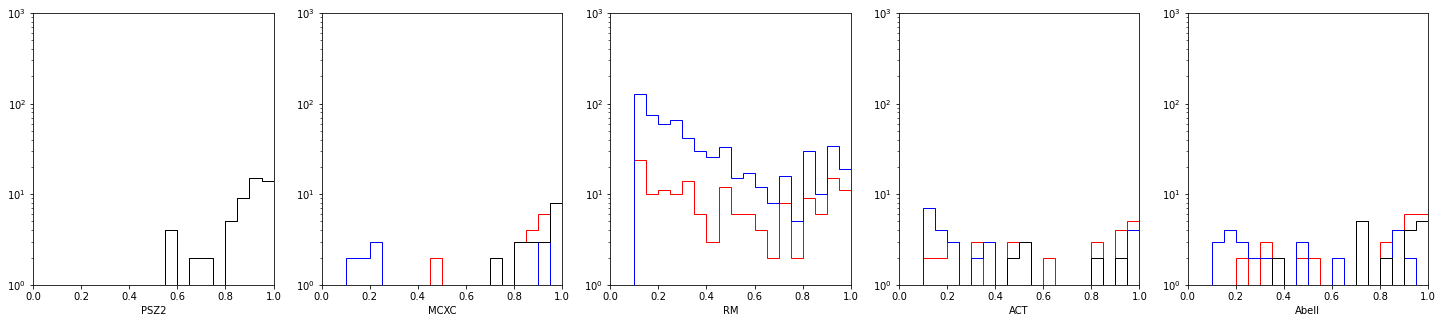

In [6]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(1, 10**3)
    match_one_by_one(ax[i], cut_cat(pd.read_csv(det_cat), big_pix = 38), 
                     cut_cat(pd.read_csv(tr_cat), big_pix = 38), name=name+'cd')
    ax[i].set_xlabel(name)

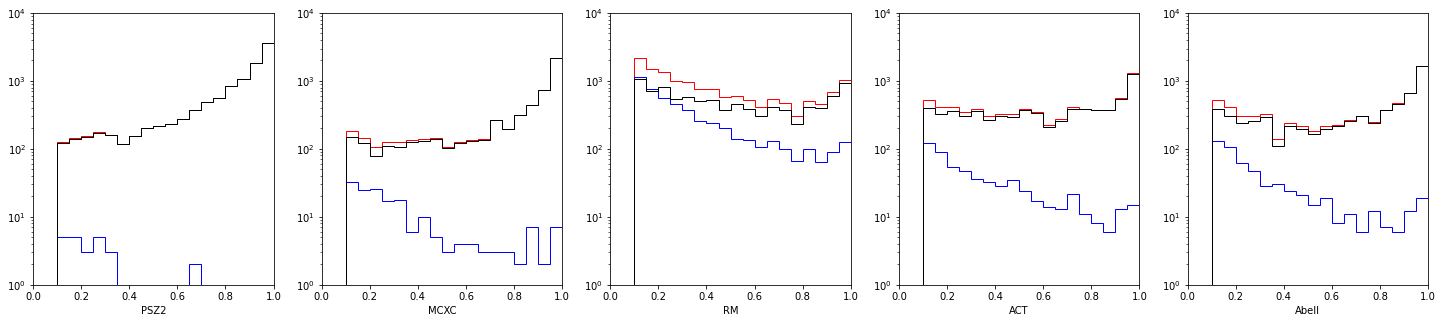

In [10]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(1, 10**4)
    match_one_by_one(ax[i], 
                     pd.read_csv(det_cat), pd.read_csv(tr_cat), name=name+'mid_', redcoef=int(blue_square/red_square), bluecoef=1,
                    n_bins=20, small_circle=400/3600, mid_circle=1000/3600, big_circle=1500/3600)
    ax[i].set_xlabel(name)

In [19]:
'{}'.format(None)

'None'

In [5]:
def match_one_by_one_constant_gt(ax, det_cat, true_cat, small_circle=400/3600, mid_circle=400/3600, 
                                 big_circle=1500/3600, name=None, filename='',
                                redname='red', bluename='blue', redcoef=1, bluecoef=1, n_bins=20):
    
    def func(angle1, angle2, det_cat, true_cat):
        colored = []
        tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')

        for i in range(len(det_cat)):
            det = SkyCoord(ra=det_cat.loc[i, 'RA']*u.degree, dec=det_cat.loc[i, 'DEC']*u.degree, frame='icrs')
            sep = tr.separation(det).degree

            count = np.count_nonzero(np.logical_and(angle1 < sep, sep <= angle2))
            colored.extend(count * [det_cat.loc[i, 'max_pred']])

        return colored 
    
    filered = '/home/rt2122/Data/cur/redblue/const_gt/{}{}_red.npy'.format(name, filename)
    fileblue = '/home/rt2122/Data/cur/redblue/const_gt/{}{}_blue.npy'.format(name, filename)

    if os.path.isfile(filered):
        red = np.load(filered)
        blue = np.load(fileblue)
    else:
        red = func(0, small_circle, det_cat, true_cat)
        blue = func(mid_circle, big_circle, det_cat, true_cat)

        if not (name is None):
            np.save(filered, np.array(red))
            np.save(fileblue, np.array(blue))
    
    make_histogram(ax, red, blue, n_bins, redname, bluename, redcoef=redcoef, bluecoef=bluecoef)

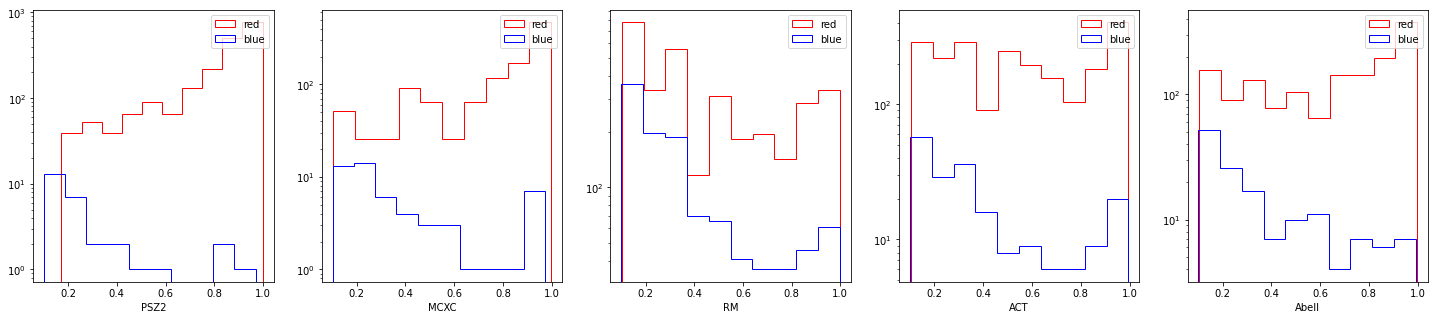

In [18]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    match_one_by_one_constant_gt(ax[i], cut_cat(pd.read_csv(det_cat), big_pix = val_pix), 
                     cut_cat(pd.read_csv(tr_cat), big_pix = val_pix), name=name, filename='val', n_bins=10, 
                                 redcoef=int(blue_square/red_square))
    ax[i].set_xlabel(name)

In [7]:
red_square=np.pi * (400 ** 2)
blue_square=np.pi * (1500 **2) - np.pi*(1000 ** 2) 
red_square, blue_square

(502654.8245743669, 3926990.816987241)

In [12]:
blue_square/red_square

7.812499999999999

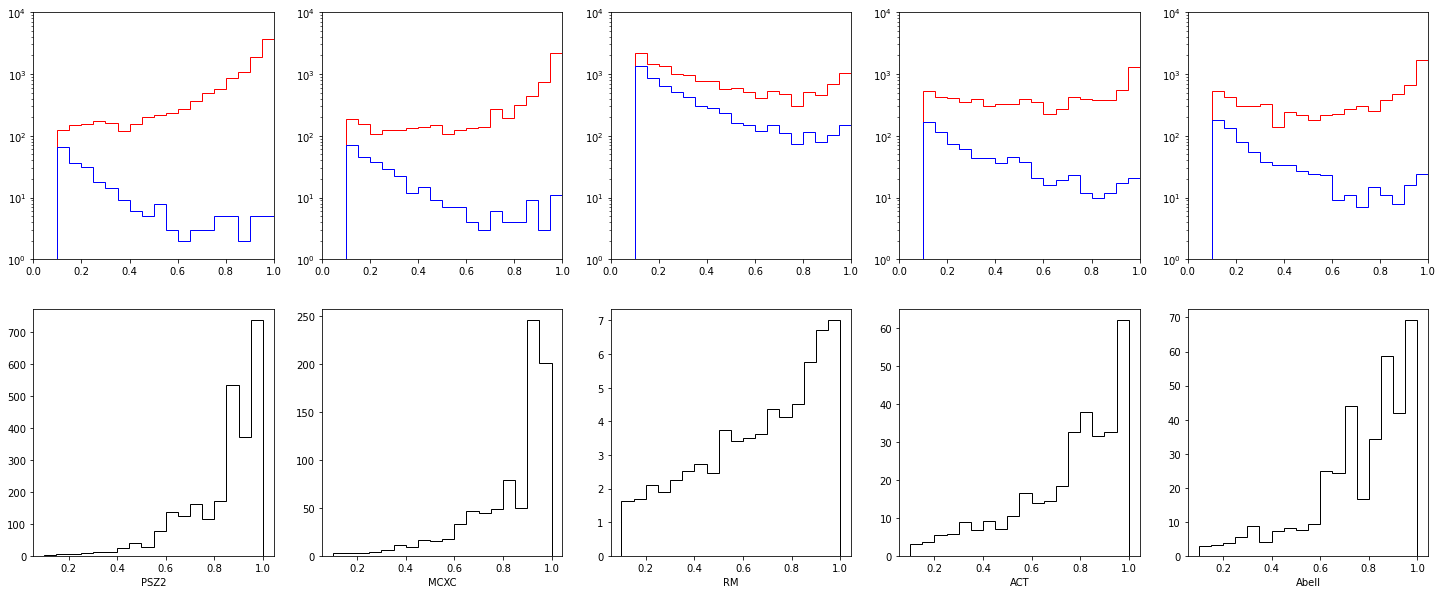

In [13]:
_, ax = plt.subplots(2, len(true_cats), figsize=(len(true_cats) * 5, 10))
for i, tr_cat in tqdm(enumerate(true_cats)):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    ax[0][i].set_xlim(0, 1)
    ax[0][i].set_ylim(1, 10**4)
    
    match_one_by_one_constant_gt([ax[0][i], ax[1][i]], pd.read_csv(det_cat), 
                     pd.read_csv(tr_cat), name=name, filename='1000-1500_', redname='found', bluename='error', 
                                 redcoef=int(blue_square/red_square), 
                                 small_circle=400/3600, mid_circle=1000/3600, big_circle=1500/3600)
    ax[1][i].set_xlabel(name)

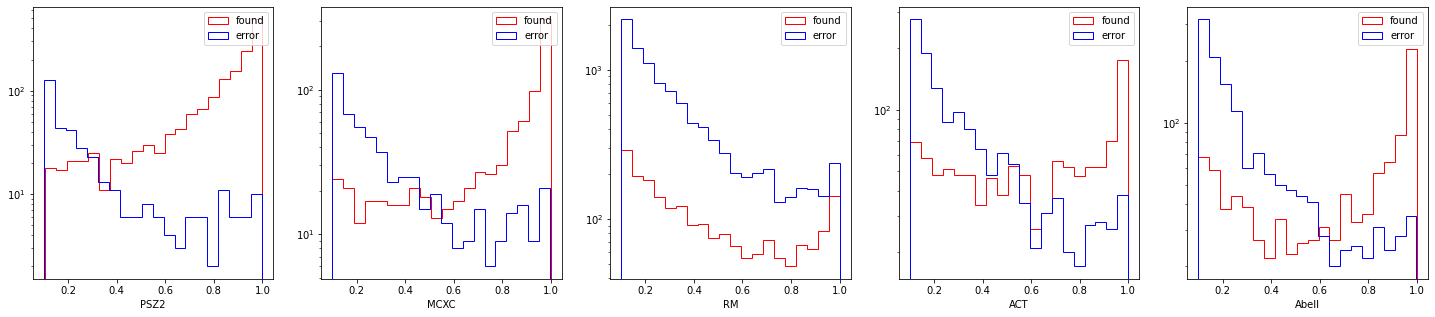

In [21]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in tqdm(enumerate(true_cats)):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    match_one_by_one_constant_gt(ax[i], pd.read_csv(det_cat), 
                     pd.read_csv(tr_cat), name=name, filename='', redname='found', bluename='error', 
                                 redcoef=1)
    ax[i].set_xlabel(name)

In [ ]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in tqdm(enumerate(true_cats)):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    match_one_by_one_constant_gt(ax[i], pd.read_csv(det_cat), 
                     pd.read_csv(tr_cat), name=name, filename='', redname='found', bluename='error', 
                                 redcoef=int(blue_square/red_square))
    ax[i].set_xlabel(name)

In [38]:
cat = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')

In [39]:
cat[cat['max_pred'] > 0.95]

RA        DEC   area   min_rad    max_rad  mean_rad  min_pred  \
1002   258.912800   0.052756   36.0  2.289824   4.342237  3.473600  0.110412   
1471   227.756081   5.665220  100.0  0.541522  17.650340  8.366707  0.100442   
3176   162.556401  64.812697   32.0  1.771288   4.389184  3.248701  0.104496   
5538   230.955106 -33.404650   23.0  1.392822   3.676397  2.751504  0.124428   
6056   232.054901 -31.219027   27.0  1.321054   3.730086  2.961099  0.105129   
...           ...        ...    ...       ...        ...       ...       ...   
23319   80.342561 -40.817055   31.0  2.268405   4.112448  3.213686  0.102983   
23329   82.204212 -39.478433   30.0  1.774505   4.061027  3.131644  0.124886   
23340   83.202141 -37.047721   32.0  2.016490   4.428141  3.271466  0.103728   
23345   94.103582 -39.842035   33.0  1.833864   4.222020  3.313638  0.102623   
23348   85.694530 -35.987890   28.0  1.860392   4.038803  3.099976  0.105760   

       max_pred        tRA       tDEC status   catalog      M500       z  \
1002   0.956089        NaN        NaN     fp       NaN       NaN     NaN   
1471   0.997097        NaN        NaN     fp       NaN       NaN     NaN   
3176   0.962947        NaN        NaN     fp       NaN       NaN     NaN   
5538   0.956504        NaN        NaN     fp       NaN       NaN     NaN   
6056   0.978701        NaN        NaN     fp       NaN       NaN     NaN   
...         ...        ...        ...    ...       ...       ...     ...   
23319  0.966914  80.384113 -40.834128     tp  planck_z  1.942717  0.0756   
23329  0.989700  82.201187 -39.477494     tp  planck_z  7.406209  0.2839   
23340  0.993524  83.231675 -37.039633     tp  planck_z  7.004796  0.2708   
23345  0.977697  94.134115 -39.832847     tp  planck_z  4.078645  0.1520   
23348  0.966874  85.737814 -35.984258     tp  planck_z  7.361269  0.4200   

            pix2  
1002   train_pix  
1471   train_pix  
3176   train_pix  
5538   train_pix  
6056   train_pix  
...          ...  
23319    val_pix  
23329    val_pix  
23340    val_pix  
23345    val_pix  
23348    val_pix  

[549 rows x 15 columns]

In [68]:
for k in zip([1, 2, 3], [3, 4]):
    print(k)

(1, 3)
(2, 4)


In [81]:
sum([[1, 2], [3, 4]])

TypeError: unsupported operand type(s) for +: 'int' and 'list'